# Predicting Student Success Using Virtual Learning Environment Interaction Statistics

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
registration_correlations, dist_by_course

from dython.nominal import associations

import pickle

import warnings

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
sns.set(font_scale=1.5)

In [2]:
df = load_OU_data(prediction_window = None)
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,268.0,268,40.0,196.0,934.0,5.0,82.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,268.0,268,80.0,430.0,1435.0,5.0,66.4
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268,12.0,76.0,281.0,0.0,0.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,268.0,268,123.0,663.0,2158.0,5.0,76.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,268.0,268,70.0,352.0,1034.0,5.0,54.4


# Preprocessing
I told you some about preparing the data, but there is more to do to overcome the problems mentioned above.

1. We will limit the data to what makes sense for our prediction window, or the points in the course we want to make our predictions on.  For one, we won't try to predict the outcomes of students who have already withdrawn.  We also won't use any data that we would not yet have by that point in the course.

2. Our data target classes are 'Distinction', 'Pass', 'Fail', and 'Withdrawn'.  However, our predictor only predicts whether a student needs intervention or not.  Those passing or passing with distinction do not need interventions, while those failing or withdrawing do.  We will combine the first two into a new class 'No Intervention' and the second two into 'Needs Intervention'.  This makes our target binary, easier to predict and easier to evaluate.  There is an argument for separating withdrawing students and failing students, but my model is not accurate at differentiating between those.  

3. We will scale all the data course by course.  The `CourseScaler` class object will fit on each individual course, as indexed by the `code_module` variable.  It will take the mean and standard deviation for each feature for each course from the training data and use these to scale each feature for each individual course `(X - mean) / standard deviation` for both the training and the testing data.  This will remove the correlations between `code_module` and the activity and assessment statistics.

4. We will use the `smotecourses()` function to apply [imblearn.over_sampling.SMOTE](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html) to the training data to create synthetic data within the minority class to balance the classes.  Each course in the training set will then have equal number of students needing intervention and not needing interventions, even though some of those students are not real, but approximations.  This will remove the correlation between `code_module` and `final_result`.  

5. Once those are done, we can drop the `code_module` column, because we don't want our model considering that in its predictions.

Let's take a look at how these steps effect our correlation matrix.

## Scaling

In [9]:
#Setting prediction_window to .5 loads data up to the halfway point of the shortest course present



In [11]:
half_df = load_OU_data(prediction_window=.5)

X = half_df.drop('final_result', axis=1)
y = half_df['final_result']

cv = KFold(n_splits = 5, shuffle=True, random_state=111)

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, random_state = 111, test_size=.2)
X_train = X_train_full.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'])
X_test = X_test_full.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'])

y_test_uncollapsed = y_test.reset_index(drop=True)
y_train = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in y_train])
y_test = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in y_test])

#the cross validator processes data as it's validating, but we want a set for final evaluation, too.
X_train_transformed, y_train_transformed, X_test_transformed = process_courses(X_train, y_train, X_test)

# eXtreme Gradient Boosting
I tried one tree, I tried a forest of trees, let's try stacking trees on top top of each and letting each one boost the one before it.  This is a trendy model these days.  Lets see how it performs.

Model Hyperparamters:
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=2, random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)
Validation scores across folds are:
[0.7858078030898141, 0.7873788949986907, 0.785751702462022, 0.7912519643792562, 0.7980618124672604]
Mean validation scores is:
0.7896504354794087
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.71      0.75      0.73      1804
   No Intervention       0.85

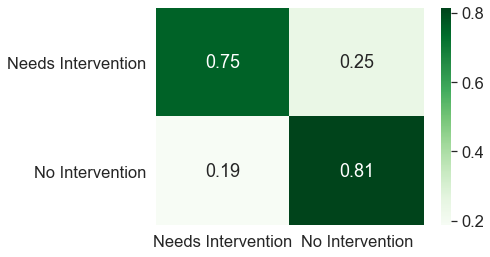

In [7]:
model = pickle.load(open('../models/XGBmodel4.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = course_cross_validate(model, X_train, y_train, cv=cv, scoring='accuracy', random_state=111)
print('Validation scores across folds are:')
print(scores)
print('Mean validation scores is:')
print(np.mean(scores))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred, save_path = '../figures/XGBoost79confmatrix.png')

XGBoost proves itself again!  It performs better on both classes and achieves 79% overall accuracy on the hold-out dataset.  The validation folds are all in line with the final results, showing it has avoided overfitting problems.

# Final model: XGBoost!
While the model accuracies are not that different, the eXtreme Gradient Boost model worked the best over all, with high accuracy and only a small amount of class bias toward 'No Intervention'.

## Evaluation:
I would like to dive deeper into the assumptions this model makes and where it does well or poorly.  First let's see what the model based it's predictions on.  The numbers below are how many times a dataset is split by a given variable, giving a rough indication of which variables are most heavily relied on by the model to classify observations in prediction.

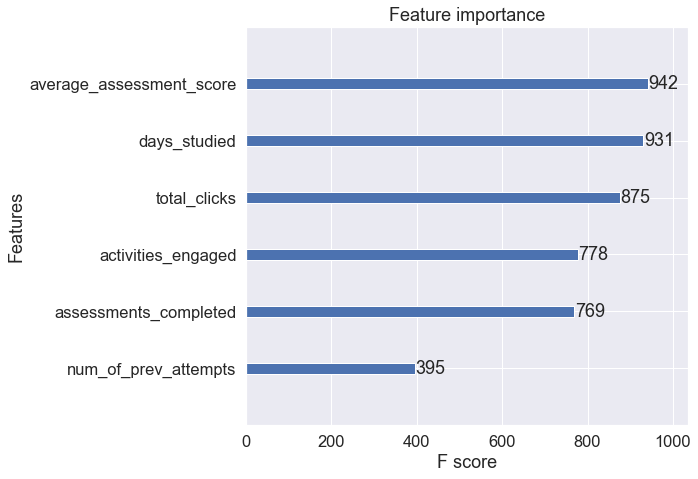

In [5]:
from xgboost import plot_importance
model = pickle.load(open('../models/XGBmodel4.pkl','rb'))
plt.figure(figsize = (10,7))
ax = plt.subplot()
plot_importance(model, ax=ax)
plt.tight_layout()
plt.savefig('../figures/XGB_final_model_feature_importance.png', dpi=100)

This seems to confirm what our correlation matrix told us.  Assessment scores are the best predictor, followed by number of separate days studied and number of assessments taken.  The biggest difference is that this model put less emphasis on activities engaged than was suggest by the correlation matrix and more on total_clicks.  However, all five of the assessment and interaction statistics rate highly, with previous attempts being lowest, but predictive.  The vast majority of students were taking the classes for the first time anyway.  Let's take a closer look at the means of these variables for all students in the test set, those who passed, those who failed, those whom the model predicted would pass and those whom the model predicted would fail.

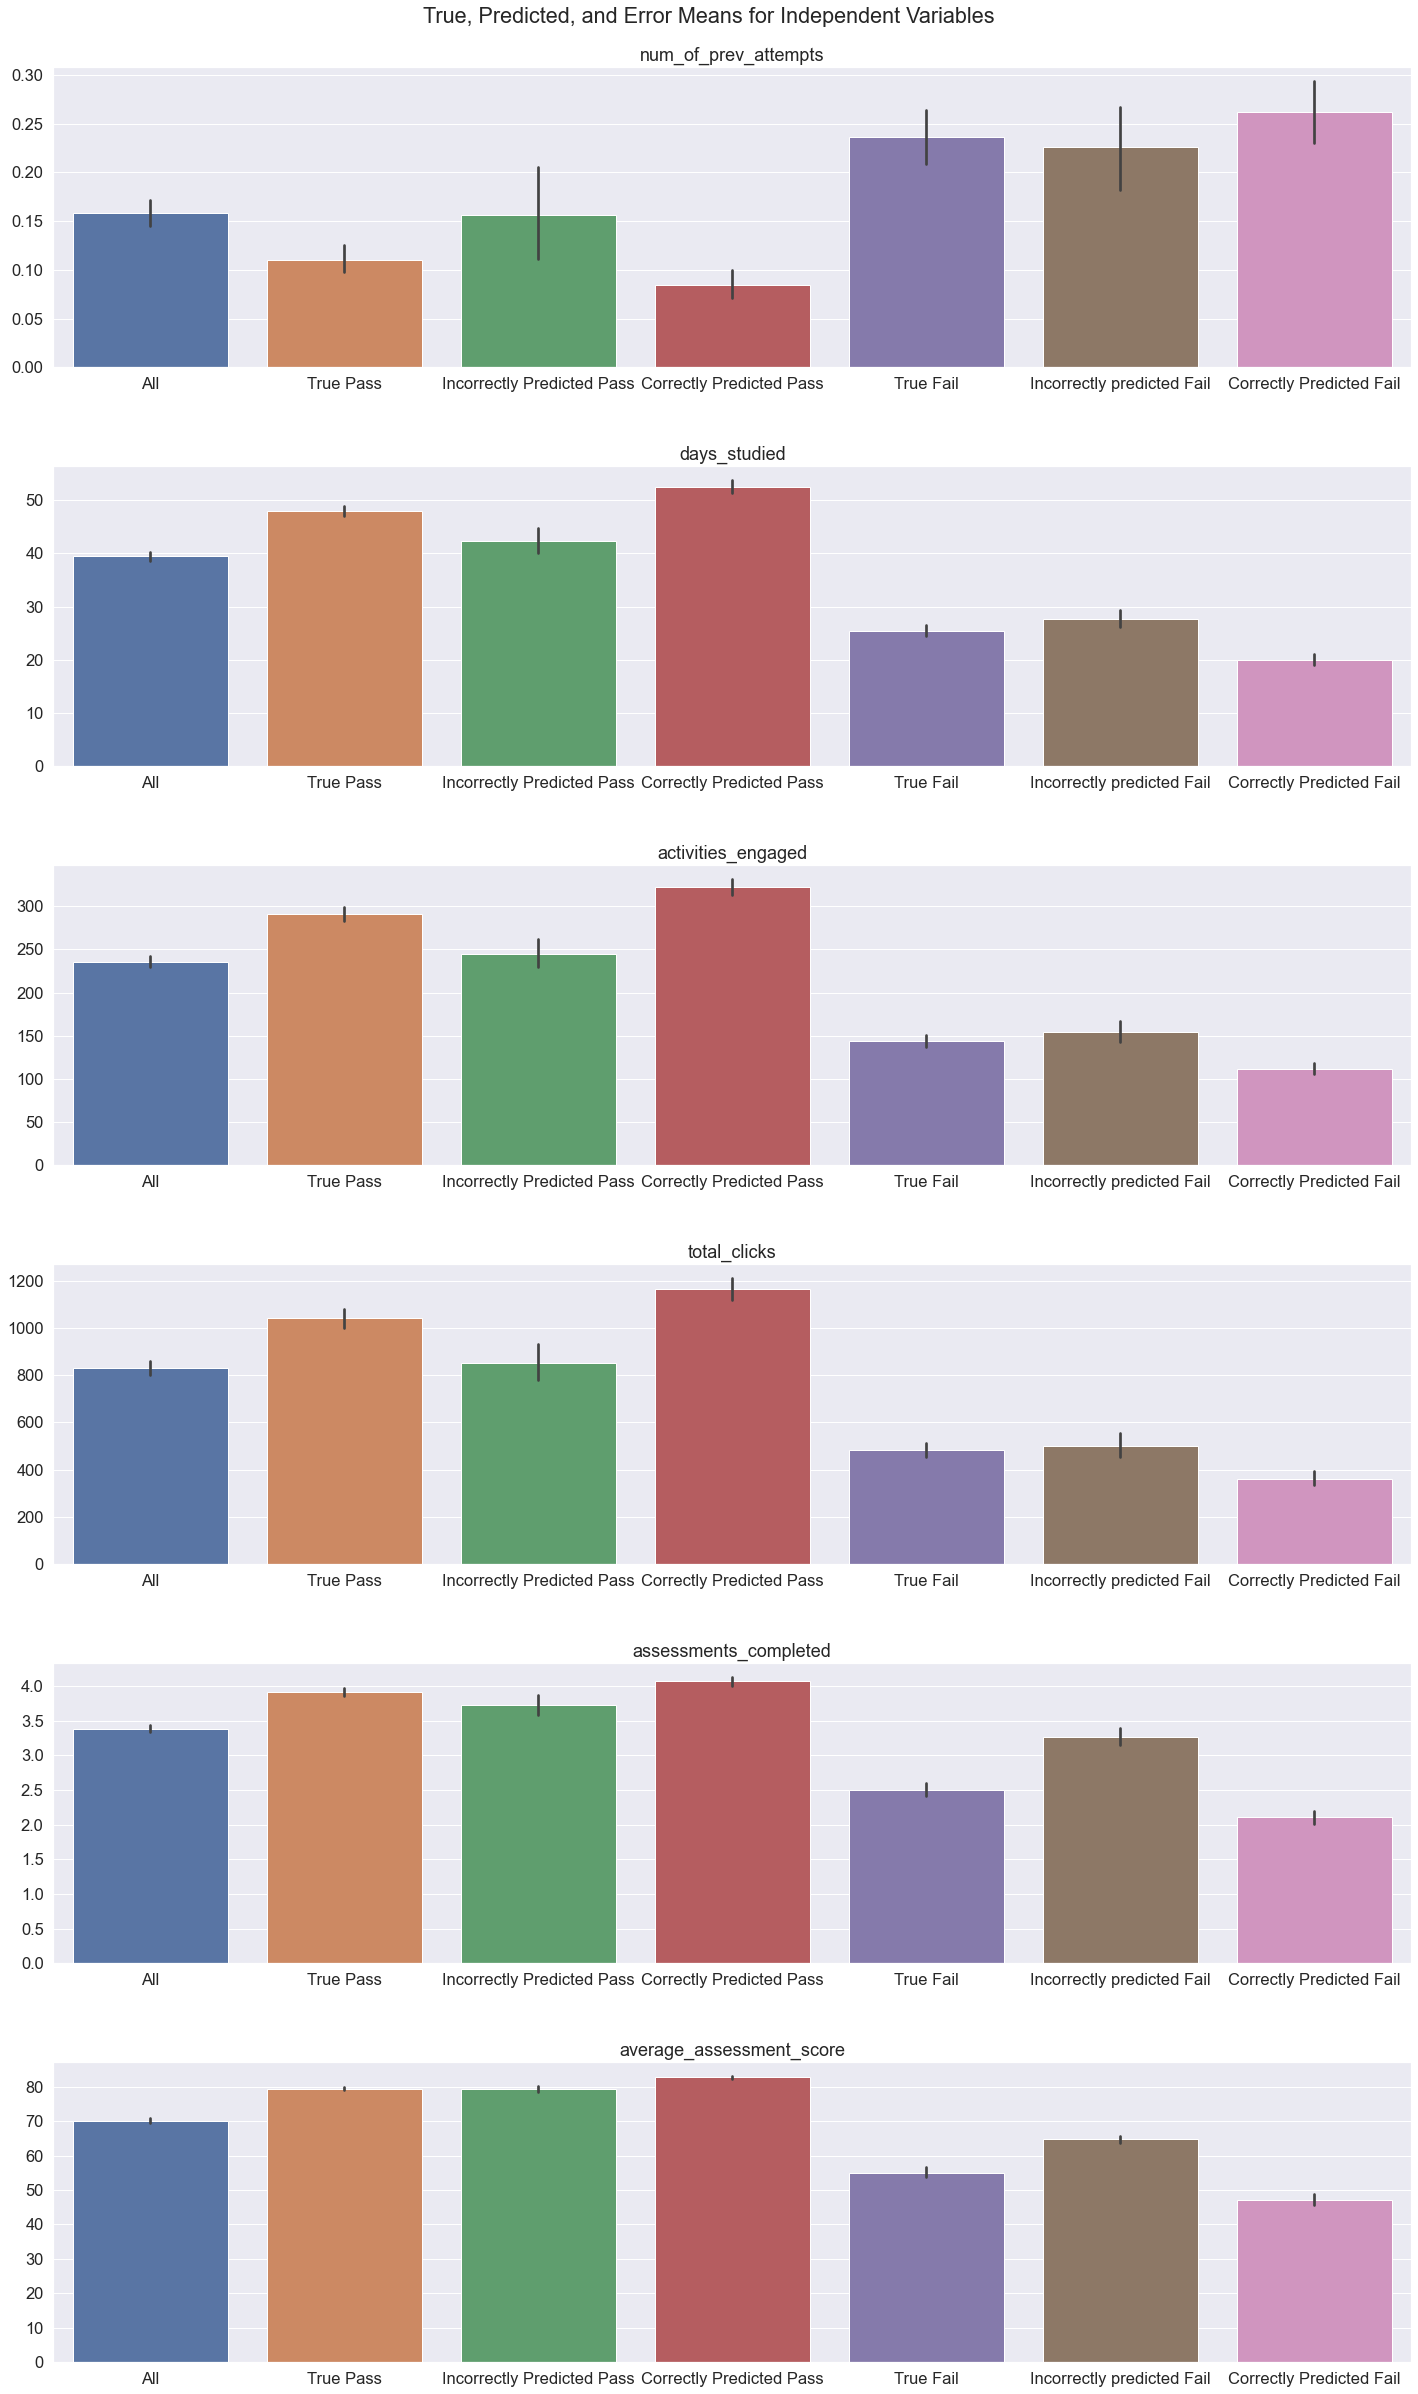

In [24]:
evaluation = X_test.copy()

evaluation['result'] = y_test
evaluation['XGB'] = y_pred
evaluation['true uncollapsed'] = y_test_uncollapsed

fig, axes = plt.subplots(6,1, figsize = (22,35))
axes = axes.ravel()
for i, column in enumerate(X_test.columns[1:]):
    to_graph = pd.DataFrame()
    to_graph['All'] = evaluation[column]
    to_graph['True Pass'] = evaluation[evaluation['result'] == 'No Intervention'][column]
    to_graph['Incorrectly Predicted Pass'] = evaluation[(evaluation['XGB'] 
                                               != evaluation['result'])
                                               & (evaluation['XGB'] == 'No Intervention')][column]    
    to_graph['Correctly Predicted Pass'] = evaluation[(evaluation['XGB'] == 'No Intervention')
                                           & (evaluation['XGB'] == evaluation['result'])][column]
    to_graph['True Fail'] = evaluation[evaluation['result'] == 'Needs Intervention'][column]
    to_graph['Incorrectly predicted Fail'] = evaluation[(evaluation['XGB'] 
                                               != evaluation['result'])
                                               & (evaluation['XGB'] == 'Needs Intervention')][column]    
    to_graph['Correctly Predicted Fail'] = evaluation[(evaluation['XGB'] == 'Needs Intervention')
                                           & (evaluation['XGB'] == evaluation['result'])][column]

    
    sns.barplot(data = to_graph, ax = axes[i])
    axes[i].set(title=column)
    
fig.tight_layout(pad = 5, h_pad = 3, w_pad = 5)
plt.suptitle('True, Predicted, and Error Means for Independent Variables')
plt.savefig('../figures/true_pred_error_var_means.png', dpi=250)
plt.show()

A note, first, these graphs are not normalized by course.  That graph is easy to make by replacing `X_test` above with `X_test_transformed`.  If you'd like to see that, I leave it to you to try that.  It's a little messier to read, though.

## Prediction Evaluation Findings:

1. There are significant differences in the true means of each of these variables between those who pass the courses and those who don't.  The black lines represent standard deviations within each group.

2. This model tended to exaggerate the difference it seemed to split on.  The average values in the predicted success groups are all a little higher than the average of the true success groups and the average failing values a little lower.  

3. The means of the predictor variables for the students that the model misclassified show they are true outliers for their class.  Their numbers are much closer to their opposite class, and it makes sense why the model misclassified them.  The information present in the model may simply be insufficient to accurate predict the outcomes for the students, and the model error may represent irreducible error with the data used.  It's possible that these are the cases where demographic data may tell a deeper story, but also may just be unique circumstances.

## Which of the original classes did the model most often misclassify?

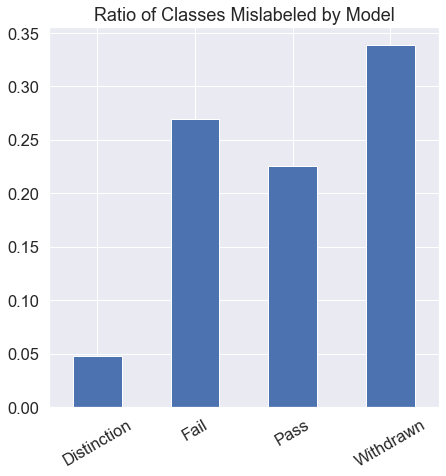

In [31]:
full_class_counts = evaluation['true uncollapsed'].value_counts()
error_class_counts = evaluation[evaluation['result'] != evaluation['XGB']]['true uncollapsed'].value_counts()
error_class_ratio = error_class_counts/full_class_counts
error_class_ratio.plot(kind = 'bar', figsize = (7,7), rot = 30)
plt.title('Ratio of Classes Mislabeled by Model')
plt.savefig('../figures/ratio_mislabeled_class_XGB.png', dpi = 70)

My model had the most trouble classifying student who would withdraw.  Perhaps these students more often had extenuating circumstances?  It was best at classifying students who would pass with distinction, but did not predict all of them!  This makes sense, as it stands to reason that students who excel would excel within the first half of the course.

### Errors by Demographics
Are some demographic groups harder to model?

In [13]:
evaluation2 = X_test_full.copy()
evaluation2['result'] = y_test
evaluation2['prediction'] = y_pred
evaluation2['correct'] = np.where(evaluation2['result'] == evaluation2['prediction'], True, False)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,module_presentation_length,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score,result,prediction
6969,CCC,2014B,537658,F,Wales,Lower Than A Level,20-30%,0-35,0,90,N,-22.0,241,6.0,12.0,21.0,0.0,0.000000,Needs Intervention,Needs Intervention
12760,DDD,2014J,556007,F,East Anglian Region,A Level or Equivalent,30-40%,0-35,1,90,N,-22.0,262,3.0,9.0,30.0,0.0,0.000000,Needs Intervention,Needs Intervention
12379,DDD,2014B,2394090,F,West Midlands Region,A Level or Equivalent,30-40%,0-35,0,90,N,-179.0,241,48.0,204.0,452.0,4.0,80.000000,No Intervention,No Intervention
16077,FFF,2013B,283230,M,North Region,A Level or Equivalent,0-10%,0-35,1,120,N,-52.0,240,57.0,440.0,1962.0,3.0,84.666667,No Intervention,No Intervention
7093,CCC,2014B,574283,M,South Region,A Level or Equivalent,20-30%,35-55,0,120,N,-255.0,241,26.0,166.0,395.0,3.0,70.000000,Needs Intervention,Needs Intervention


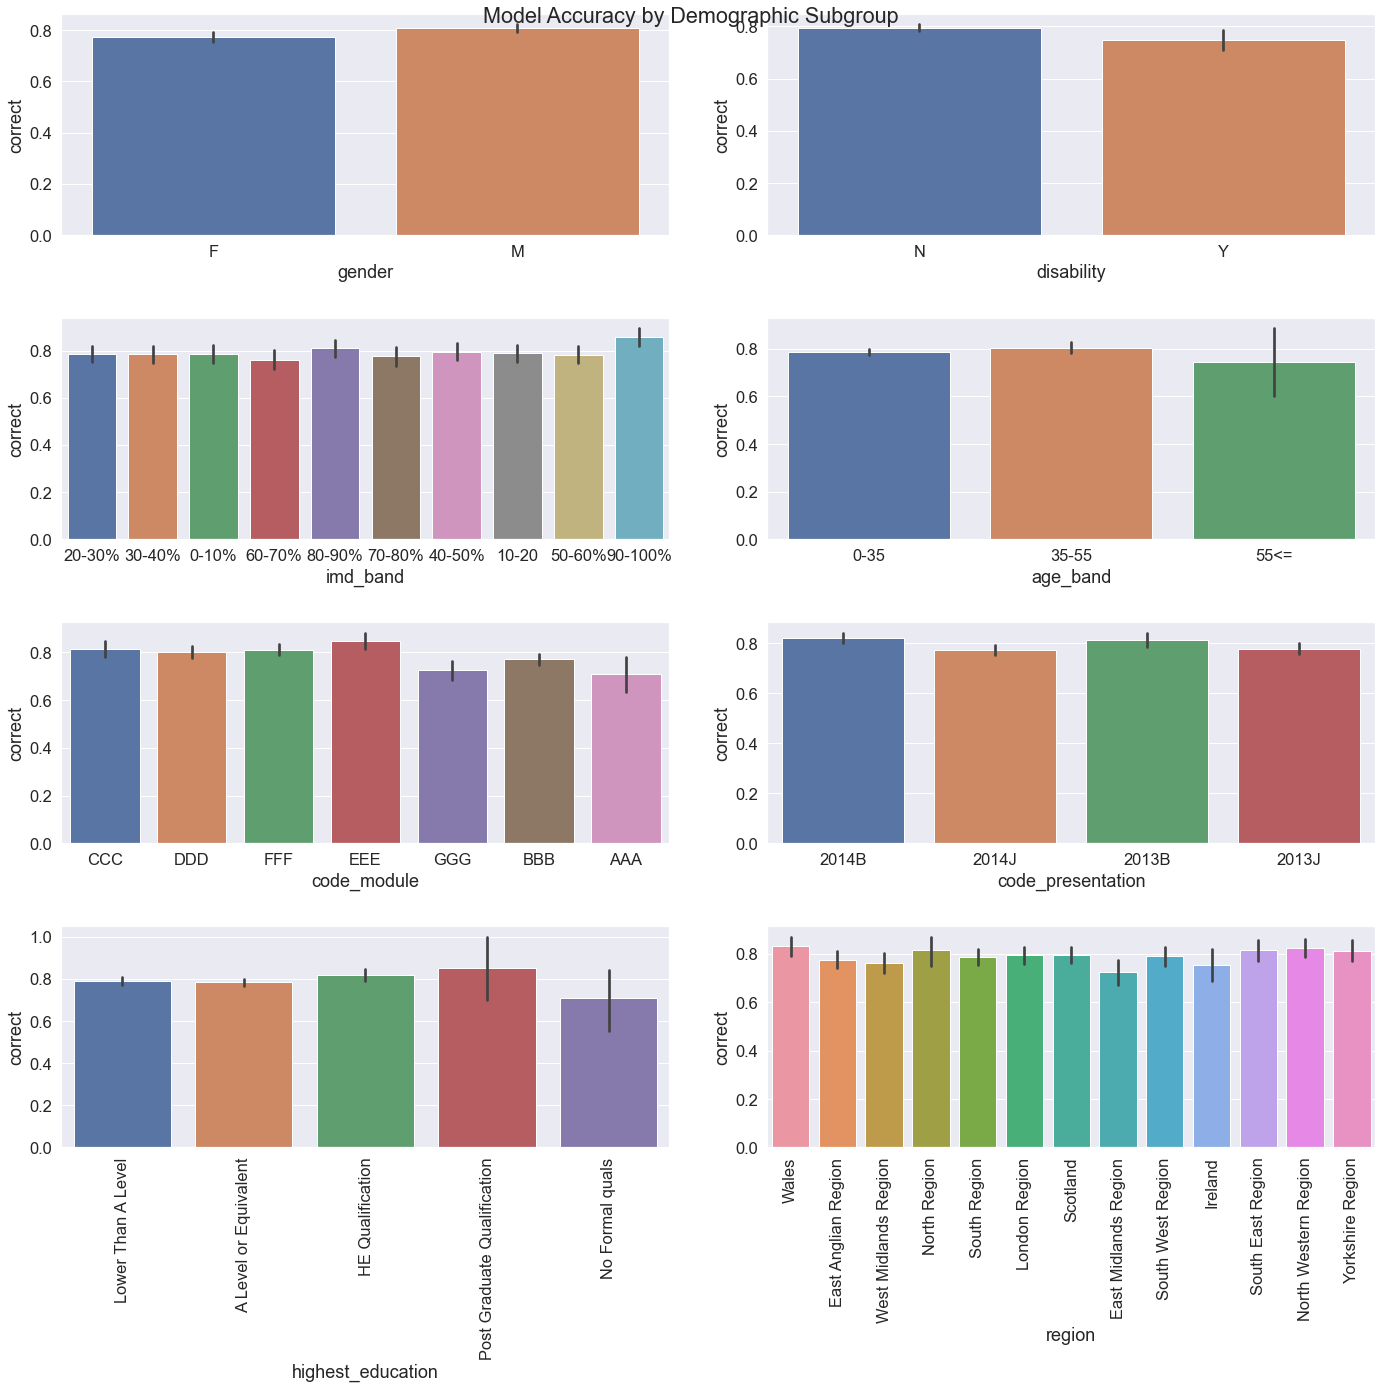

In [44]:
columns = ['gender','disability','imd_band','age_band', 'code_module','code_presentation',
           'highest_education','region']
fig, axes = plt.subplots(4,2, figsize = (20,20))
axes = axes.ravel()
for i, column in enumerate(columns):
    sns.barplot(data=evaluation2, x=column, y='correct', ax=axes[i])
plt.setp(axes[6].xaxis.get_majorticklabels(), rotation=90)
plt.setp(axes[7].xaxis.get_majorticklabels(), rotation=90)

plt.suptitle('Model Accuracy by Demographic Subgroup')
plt.tight_layout(pad=2)
plt.savefig('accuracy_by_demographic.png', dpi=150)

My model mostly predicts well, between 75% and 85% accuracy, across demographic groups.  The exceptions are students with no formal educational qualifications (did not graduate high school), students from the East Midlands Region of Great Britain, and students in AAA and GGG modules.  Those are both Social Sciences, and I wonder about the connection to that.  The model is particularly good at modeling the success of students with low deprivation scores and with more education.  Many of these groups are small, especially post-grads students in module AAA, and students over 55.  You can tell by the large confidence intervals (black lines).

## Can my model predict student outcomes in a later presentation based on students in a previous presentation?

In [63]:
time_X_train = half_df[half_df['code_presentation'].isin(['2013B','2013J','2014B'])]
time_X_test = half_df[half_df['code_presentation'] == '2014J']
time_y_train = time_X_train['final_result']
time_X_train = time_X_train.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration','final_result'])
time_y_test = time_X_test['final_result']
time_X_test = time_X_test.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration','final_result'])
time_y_train = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in time_y_train])
time_y_test = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in time_y_test])
time_X_train_transformed, time_y_train_transformed, time_X_test_transformed \
                    = process_courses(time_X_train, time_y_train, time_X_test)

Model Hyperparamters:
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=2, random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)
Validation scores across folds are:
[0.784750549105742, 0.8079698776278632, 0.8048321305302792, 0.8048321305302792, 0.8045183558205209]
Mean validation scores is:
0.8013806087229369
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.53      0.74      0.62      2735
   No Intervention       0.83

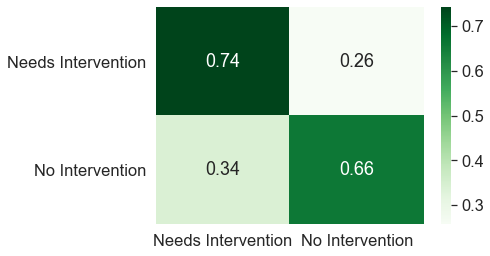

In [64]:
model = pickle.load(open('../models/XGBmodel4.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = course_cross_validate(model, time_X_train, time_y_train, cv=cv, scoring='accuracy', random_state=111)
print('Validation scores across folds are:')
print(scores)
print('Mean validation scores is:')
print(np.mean(scores))
model.fit(time_X_train_transformed, time_y_train_transformed)
y_pred = model.predict(time_X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(time_y_test, y_pred))
plot_confusion(time_y_test, y_pred)